#Using CNNs to Classify Aerial Images of Field Segments

##Brody Vogel

Mount Google Drive (where the images are)

If you're running this, be sure the images are in your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


Get to the proper directory and import some needed libraries.

In [2]:
% cd gdrive/'My Drive'/Crop-Classification-Project

import os
import shutil
import random as rand

% cd dataset
#os.listdir()

/content/gdrive/My Drive/Crop-Classification-Project
/content/gdrive/My Drive/Crop-Classification-Project/dataset


Look at the labels and class (im)balance.

In [3]:
# look at number of labels and images for each
imgsource = "./Images"
labels = os.listdir(imgsource)
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print(num_classes, ':', num_imgs)
print(labels)

4 : [3249, 1191, 3537, 7381]
['soil', 'broadleaf', 'grass', 'soybean']


##Create a Train / Test Split (If Wanted)

In [0]:
# check if train/test split needs to be generated
trainpath = "./TrainSet"
testpath = "./TestSet"
split = input("Generate train/test split? (y/n)\t")
if split.lower()=='y':
  split_into_train_test = True
else:
  split_into_train_test = False
  

Generate train/test split? (y/n)	y


In [0]:
# generate train/test split if 'y'
if split_into_train_test:
  # delete directories if they already exist
  if 'TrainSet' in os.listdir():
    ! rm -r TrainSet
  if 'TestSet' in os.listdir():
    ! rm -r TestSet
  # generate new folders
  os.makedirs(trainpath)
  os.makedirs(testpath)
  # for each label generate new folders
  for fold in labels:
    # to keep track of time
    print(fold)
    # randomly shuffle whether to copy image
    img_files = os.listdir(imgsource+'/'+fold)
    os.makedirs(trainpath+'/'+fold)
    os.makedirs(testpath+'/'+fold)
    split = [True]*int(.2 * len(img_files))+[False]*int(.8 * len(img_files) + 3)
    rand.shuffle(split)
    for f in img_files:
      if split.pop():
        shutil.copyfile(imgsource+'/'+fold+'/'+f, testpath+'/'+fold+'/'+f)
      else:
        shutil.copyfile(imgsource+'/'+fold+'/'+f, trainpath+'/'+fold+'/'+f)

broadleaf
1193
1191
soybean
7383
7381
soil
3251
3249
grass
3539
3537


Import more libraries.

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import RMSprop

import numpy as np
import os
from scipy import ndimage, signal
from scipy.signal import convolve2d
import cv2
from PIL import Image
from sklearn.metrics import roc_curve, auc

Take a look at an image from each class.

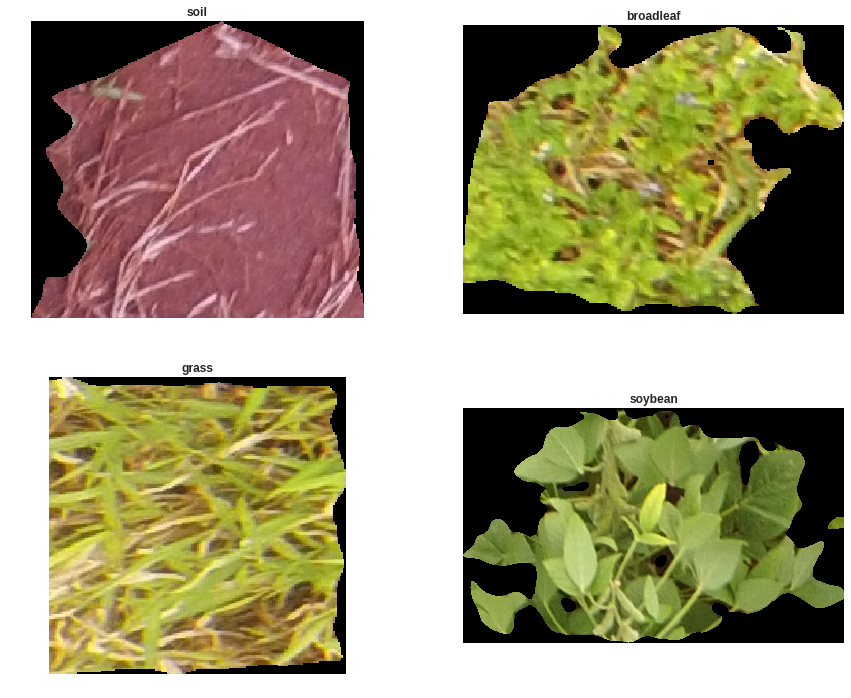

In [7]:
# display images from training data
plt.figure(figsize=(15, 12))
where = 1
for x in range(len(labels)):
  l = labels[x]
  f = os.listdir('./TrainSet/'+l+'/')
  plt.subplot(2, 2, where)
  plt.grid(False)
  plt.axis("off")
  plt.title(l, fontweight = 'bold')
  plt.imshow(load_img('./TrainSet/'+l+'/'+f[0]))
  where += 1
#plt.tight_layout()
plt.show()

##Remove Damaged Images

Only need to run this once.

In [6]:
# if the image can't be opened, the model can't train on it (errors out)
  # so this throws those image out
   # takes about an hour

from PIL import Image
for label in os.listdir("./TrainSet/"):
  print(label)
  folder_path = "./TrainSet/" + label
  for image in os.listdir(folder_path):
    try:
      image_path = folder_path + "/" + image
      i = Image.open(image_path)
    except:
      image_path = folder_path + "/" + image
      os.remove(image_path)
      print("removed", image_path)
      
for label in os.listdir("./TestSet/"):
  print(label)
  folder_path = "./TestSet/" + label
  for image in os.listdir(folder_path):
    try:
      image_path = folder_path + "/" + image
      i = Image.open(image_path)
    except:
      image_path = folder_path + "/" + image
      os.remove(image_path)
      print("removed", image_path)

broadleaf
soybean
soil
grass
broadleaf
soybean
soil
grass


##Improve the Images

Only need to run this once, too.

In [18]:
altered_trainpath = "./AlteredTrainSet"
altered_testpath = "./AlteredTestSet"

# uncomment the first time you run it
#os.makedirs(altered_trainpath)
#os.makedirs(altered_testpath)

# build the sharpening kernel
blur = -.2
dim = 5
top_and_bottom = np.asarray([blur] * (int((dim - 1)/2)*dim))
kernel = top_and_bottom.reshape((int((dim - 1)/2), dim))
middle = [(-dim * dim + 1) * blur + 1]
middle = np.asarray([blur] * int((dim - 1)/2) + middle + [blur] * int((dim - 1)/2))
kernel = np.concatenate((top_and_bottom, middle))
kernel_sharpening = np.concatenate((kernel, top_and_bottom)).reshape((dim, dim))

# create the color threshold (vaguely, all the greens)
lower = np.array([75, 100, 0])
upper = np.array([255, 255, 255])

# go through all the images in the training set
for label in os.listdir("./TrainSet/"):
  print(label)
  direct = "./TrainSet/" + label + "/"
  new_direct = altered_trainpath + "/" + label
  if label not in os.listdir(altered_trainpath):
    os.makedirs(new_direct)
  for image in os.listdir(direct):
    image_path = direct + image
    # open the image
    img1 = Image.open(image_path)
    img = np.array(img1)
    # can un-comment if you want - I got slightly better results without shrinking the images
    #s1 = np.int(img.shape[0] / 2)
    #s2 = np.int(img.shape[1] / 2)

    #img = img[(s1-75):(s1+75), (s2-75):(s2+75)]
    # apply the sharpening filter we made above
    sharpened = cv2.filter2D(img, -1, kernel_sharpening)
    
    # create and apply the color thresholding mask
    mask = cv2.inRange(sharpened, lower, upper)
    res = cv2.bitwise_and(sharpened, sharpened, mask = mask)
    
    # apply a median blurring filter
    blurred = cv2.medianBlur(res, 5)
    
    # make the new image
    new_path = new_direct + "/" + image 
  
    cv2.imwrite(new_path, blurred)
    
# repeat the process for the test set
for label in os.listdir("./TestSet/"):
  print(label)
  direct = "./TestSet/" + label + "/"
  new_direct = altered_testpath + "/" + label
  if label not in os.listdir(altered_testpath):
    os.makedirs(new_direct)
  for image in os.listdir(direct):
    image_path = direct + image
  
    img1 = Image.open(image_path)
    img = np.array(img1)

    #s1 = np.int(img.shape[0] / 2)
    #s2 = np.int(img.shape[1] / 2)

    #img = img[(s1-75):(s1+75), (s2-75):(s2+75)]
  
    sharpened = cv2.filter2D(img, -1, kernel_sharpening)
    mask = cv2.inRange(sharpened, lower, upper)
  
    res = cv2.bitwise_and(sharpened, sharpened, mask = mask)
  
    blurred = cv2.medianBlur(res, 5)
  
    new_path = new_direct + "/" + image 
  
    cv2.imwrite(new_path, blurred)    


broadleaf
soybean
soil
grass


This adds a directory of black and white photos (which don't do as well).

In [22]:
altered_trainpath_bw = "./AlteredTrainSetBW"
altered_testpath_bw = "./AlteredTestSetBW"

# uncomment the first time you run it
#os.makedirs(altered_trainpath_bw)
#os.makedirs(altered_testpath_bw)

for label in os.listdir("./AlteredTrainSet/"):
  print(label)
  direct = "./AlteredTrainSet/" + label + "/"
  new_direct = altered_trainpath_bw + "/" + label
  if label not in os.listdir(altered_trainpath_bw):
    os.makedirs(new_direct)
  for image in os.listdir(direct):
    image_path = direct + image
  
    img1 = Image.open(image_path)
    img = np.array(img1)

    black_white = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    black_white = np.expand_dims(black_white, axis = 2)
  
    new_path = new_direct + "/" + image 
  
    cv2.imwrite(new_path, black_white)
    
for label in os.listdir("./AlteredTestSet/"):
  print(label)
  direct = "./AlteredTestSet/" + label + "/"
  new_direct = altered_testpath_bw + "/" + label
  if label not in os.listdir(altered_testpath_bw):
    os.makedirs(new_direct)
  for image in os.listdir(direct):
    image_path = direct + image
  
    img1 = Image.open(image_path)
    img = np.array(img1)

    black_white = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    black_white = np.expand_dims(black_white, axis = 2)
  
    new_path = new_direct + "/" + image 
  
    cv2.imwrite(new_path, black_white)



broadleaf
soybean
soil
grass


##Add Slightly Distorted Images to Train and Test Set

This is for the un-altered images.

In [8]:
# build image generators for models
path_train_data = "./TrainSet/"
path_test_data = "./TestSet/"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_train_data,
        classes = labels,
        target_size=(256, 256),
        batch_size=50,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_test_data,
        classes = labels,
        target_size=(256,256),
        batch_size=25,
        class_mode='categorical')

Found 11973 images belonging to 4 classes.
Found 3012 images belonging to 4 classes.


Do the same thing for the altered images.

In [5]:
path_train_data1 = "./AlteredTrainSet/"
path_test_data1 = "./AlteredTestSet/"

train_datagen1 = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen1 = ImageDataGenerator(rescale=1./255)

# notice the different size - 150x150 here
altered_train_generator = train_datagen1.flow_from_directory(
        path_train_data1,
        classes = labels,
        target_size=(256, 256),
        batch_size=100,
        class_mode='categorical')

altered_test_generator = test_datagen1.flow_from_directory(
        path_test_data1,
        classes = labels,
        target_size=(256,256),
        batch_size=50,
        class_mode='categorical')

Found 11973 images belonging to 4 classes.
Found 3011 images belonging to 4 classes.


Do the same thing for the black and white altered images.

In [23]:
path_train_data_bw = "./AlteredTrainSetBW/"
path_test_data_bw = "./AlteredTestSetBW/"

train_datagen_bw = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen_bw = ImageDataGenerator(rescale=1./255)

# notice the different size - 150x150 here
altered_train_generator_bw = train_datagen_bw.flow_from_directory(
        path_train_data_bw,
        classes = labels,
        target_size=(256, 256),
        batch_size=100,
        class_mode='categorical')

altered_test_generator_bw = test_datagen_bw.flow_from_directory(
        path_test_data_bw,
        classes = labels,
        target_size=(256,256),
        batch_size=50,
        class_mode='categorical')

Found 11973 images belonging to 4 classes.
Found 3011 images belonging to 4 classes.


##Evaluation Functions

In [0]:
# function to plot performance
def plotModPerf(mod):
  acc = mod.history['acc']
  val_acc = mod.history['val_acc']
  loss = mod.history['loss']
  val_loss = mod.history['val_loss']

  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(15, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = 'Training loss')
  plt.plot(epochs, val_loss, label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label = 'Training acc')
  plt.plot(epochs, val_acc, label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

In [0]:
# generate predictions given model and image generator
def generate_predictions(model, img_gen):
  image = []
  y_label = []
  y_1hotlabel = []
  y_pred = []
  y_pred_prob = []
  
  for i in range(len(img_gen)):
    xs, ys = img_gen.next()
    preds = model.predict(xs)
    for p, y, x in list(zip(preds, ys, xs)):
      image.append(x)
      y_1hotlabel.append(y)
      y_label.append(class_labels[str(np.argmax(y))])
      y_pred_prob.append(p)
      y_pred.append(class_labels[str(np.argmax(p))])
  correct = [l==p for l, p in zip(y_label, y_pred)]
  print("Accuracy score: ", str(np.mean(correct)))
  return(y_label, y_1hotlabel, y_pred, y_pred_prob, image)

# plot up to 25 misclassified images given predictions
def plotMisclassifications(predictions):
  misclass = []
  for y_label, y_1hotlabel, y_pred, y_pred_prob, image in list(zip(*predictions)):
      if y_label != y_pred:
        misclass.append((y_label, y_pred, image))
  
  plt.figure(figsize=(15, 15))  
  n = min(5, int(np.ceil(np.sqrt(len(misclass)))))
  ind = 1
  for y, yhat, x in misclass:
    if ind <= 25:
      plt.subplot(5, 5, ind)  
      plt.grid(False)
      plt.axis('off')
      plt.title(y+'->\n'+yhat, fontsize=10, color='red')
      plt.imshow(x)
    ind +=1
  plt.show()
  misclass = [y+'->'+yhat for y, yhat, x in misclass]
  [print(cnt) for cnt in Counter(misclass).most_common()]
  
# plot ROC curves for each class
def plotROC(y_label, y_score, n_classes):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  plt.figure(figsize=(16, 16))
  for i in range(n_classes):
    plt.subplot(5, 5, i+1)
    fpr[i], tpr[i], _ = roc_curve(y_label[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = class_labels[str(i)])
    plt.title('AUC: '+str(roc_auc[i]), fontsize=10)
    plt.plot([0,1], [0,1])
    plt.legend()
  plt.show()

# generate confusion matrix heatmap
def plotConfusionMatrix(y_label, y_pred):
  plt.figure(figsize=(15, 10))
  cnf_matrix = confusion_matrix(y_label, y_pred, labels = labels)
  df = pd.DataFrame(data=cnf_matrix, columns=labels, index = labels)
  sns.heatmap(df, annot=True, fmt="d")
  plt.title('Confusion Matrix', fontsize=10)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

##Build and Train the Models

###Xception and Inception Models

(These don't perform nearly as well as the VGG16 below).

I don't recommend running these.

Import the base models.

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

Build, Complie, and Train.

In [7]:
# build CNN with transfer learning using InceptionV3
conv_base = Xception(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(150, activation="relu"))
#model.add(Dense(256, activation = "relu"))
model.add(Dense(4, activation="softmax"))
conv_base.trainable = False
model.summary()


83689472/83683744 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7680150   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 604       
Total params: 28,542,234
Trainable params: 7,680,754
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
# compile model
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

This is the model trained on the original, unaltered images.

In [0]:
base_model = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10, 
                                            validation_data=test_generator, validation_steps=25, verbose = 1)

In [9]:
# train the model
xception_learning = model.fit_generator(train_generator1, steps_per_epoch=100, epochs=10, 
                                            validation_data=test_generator1, validation_steps=25, verbose = 1)

Epoch 1/10
100/100 [==============================] - 5435s 54s/step - loss: 0.7018 - acc: 0.7802 - val_loss: 0.5807 - val_acc: 0.8032
Epoch 2/10
100/100 [==============================] - 1082s 11s/step - loss: 0.3293 - acc: 0.8846 - val_loss: 1.5399 - val_acc: 0.6704
Epoch 3/10
100/100 [==============================] - 256s 3s/step - loss: 0.2887 - acc: 0.8963 - val_loss: 1.0438 - val_acc: 0.7764
Epoch 4/10
100/100 [==============================] - 97s 969ms/step - loss: 0.2535 - acc: 0.9105 - val_loss: 1.0065 - val_acc: 0.7848
Epoch 5/10
100/100 [==============================] - 103s 1s/step - loss: 0.2240 - acc: 0.9203 - val_loss: 1.8211 - val_acc: 0.7178
Epoch 6/10
100/100 [==============================] - 103s 1s/step - loss: 0.2348 - acc: 0.9170 - val_loss: 0.9892 - val_acc: 0.8120
Epoch 7/10
100/100 [==============================] - 103s 1s/step - loss: 0.2140 - acc: 0.9225 - val_loss: 2.0482 - val_acc: 0.6984
Epoch 8/10
100/100 [==============================] - 103s 1s/s

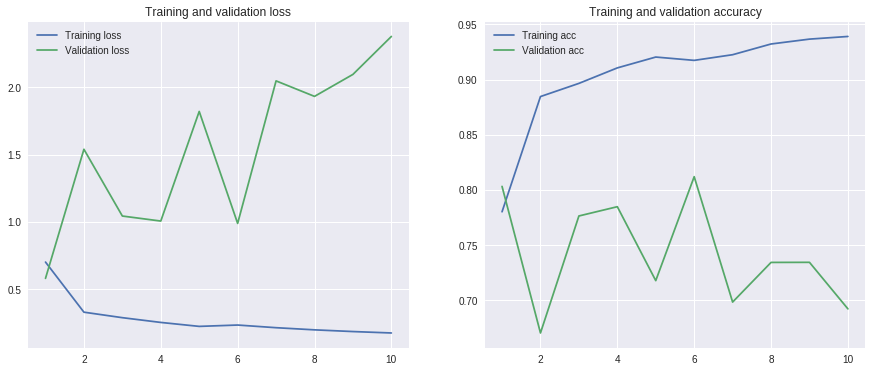

In [11]:
# function to plot performance
plotModPerf(xception_learning)

In [12]:
# build CNN with transfer learning using InceptionV3
incep_conv_base = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
incep_model = Sequential()
incep_model.add(incep_conv_base)
incep_model.add(Flatten())
incep_model.add(Dense(150, activation="relu"))
#model.add(Dense(256, activation = "relu"))
incep_model.add(Dense(4, activation="softmax"))
incep_conv_base.trainable = False
incep_model.summary()

87916544/87910968 [==============================] - 8s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               2764950   
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 604       
Total params: 24,568,338
Trainable params: 2,765,554
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
# compile model
incep_model.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [14]:
# train the model
incep_learning = incep_model.fit_generator(train_generator1, steps_per_epoch=100, epochs=10, 
                                            validation_data=test_generator1, validation_steps=25, verbose = 1)

Epoch 1/10
100/100 [==============================] - 105s 1s/step - loss: 0.7474 - acc: 0.7398 - val_loss: 1.0523 - val_acc: 0.7112
Epoch 2/10
100/100 [==============================] - 94s 944ms/step - loss: 0.4150 - acc: 0.8554 - val_loss: 1.3162 - val_acc: 0.6782
Epoch 3/10
100/100 [==============================] - 96s 960ms/step - loss: 0.3458 - acc: 0.8799 - val_loss: 1.2105 - val_acc: 0.6928
Epoch 4/10
100/100 [==============================] - 96s 960ms/step - loss: 0.3077 - acc: 0.8903 - val_loss: 1.3578 - val_acc: 0.7328
Epoch 5/10
100/100 [==============================] - 96s 955ms/step - loss: 0.2871 - acc: 0.8950 - val_loss: 1.8278 - val_acc: 0.6526
Epoch 6/10
100/100 [==============================] - 96s 960ms/step - loss: 0.2608 - acc: 0.9051 - val_loss: 1.4696 - val_acc: 0.6976
Epoch 7/10
100/100 [==============================] - 96s 961ms/step - loss: 0.2471 - acc: 0.9078 - val_loss: 1.5116 - val_acc: 0.6881
Epoch 8/10
100/100 [==============================] - 96s

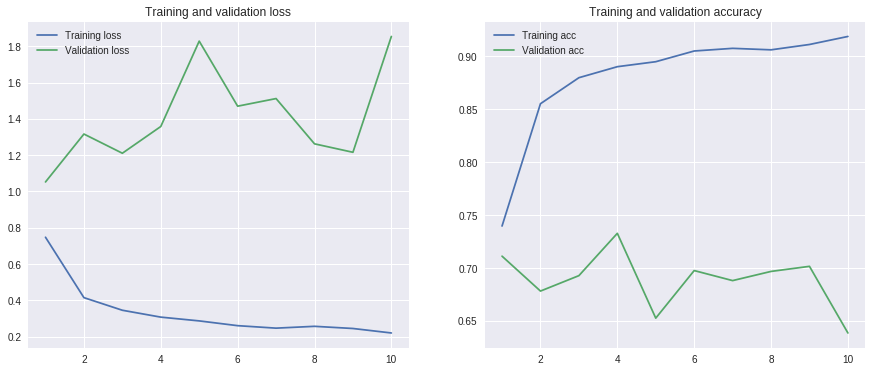

In [17]:
# function to plot performance
plotModPerf(incep_learning)

###VGG16 Models

These perform the best (over 97% accuracy).

In [9]:
from keras.applications.vgg16 import VGG16

# build CNN with transfer learning using VGG16
vgg_conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
vgg_model = Sequential()
vgg_model.add(vgg_conv_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation="relu"))
vgg_model.add(Dense(4, activation="softmax"))
vgg_conv_base.trainable = False
vgg_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


Load the weights if you've run this before; otherwise train the model and save the weights to save yourself a few hours.

In [0]:
# compile model
vgg_model.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

# load model weights
vgg_model.load_weights('vgg_altered_weights.h5')

In [11]:
# train the model
vgg_learning = vgg_model.fit_generator(altered_train_generator, steps_per_epoch=100, epochs=10, 
                                            validation_data=altered_test_generator, validation_steps=25, verbose = 1)
# save the weights
vgg_model.save_weights('vgg_altered_weights.h5')

Epoch 1/10
100/100 [==============================] - 3775s 38s/step - loss: 0.0354 - acc: 0.9862 - val_loss: 0.1109 - val_acc: 0.9696
Epoch 2/10
100/100 [==============================] - 894s 9s/step - loss: 0.0297 - acc: 0.9886 - val_loss: 0.0503 - val_acc: 0.9776
Epoch 3/10
100/100 [==============================] - 232s 2s/step - loss: 0.0271 - acc: 0.9895 - val_loss: 0.0385 - val_acc: 0.9843
Epoch 4/10
100/100 [==============================] - 238s 2s/step - loss: 0.0246 - acc: 0.9916 - val_loss: 0.0455 - val_acc: 0.9808
Epoch 5/10
100/100 [==============================] - 238s 2s/step - loss: 0.0256 - acc: 0.9915 - val_loss: 0.0743 - val_acc: 0.9769
Epoch 6/10
100/100 [==============================] - 238s 2s/step - loss: 0.0259 - acc: 0.9903 - val_loss: 0.0451 - val_acc: 0.9864
Epoch 7/10
100/100 [==============================] - 238s 2s/step - loss: 0.0193 - acc: 0.9926 - val_loss: 0.0949 - val_acc: 0.9736
Epoch 8/10
100/100 [==============================] - 237s 2s/step 

##Best Results (VGG16 on the Altered Images)

Loss and Accuracy

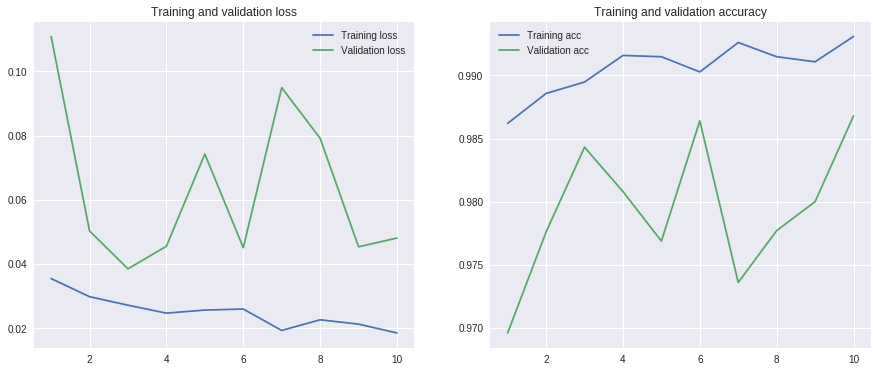

In [12]:
plotModPerf(vgg_learning)

ROC Curves (False Positive Rate vs True Positive Rate)

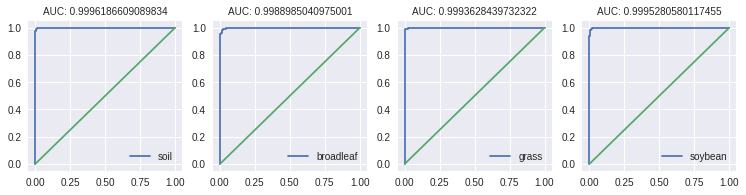

In [22]:
class_labels = {}
# switch key and values for class labels
for k, v in altered_test_generator.class_indices.items():
  class_labels[str(v)]=k

preds = generate_predictions(vgg_model, altered_test_generator)

y_label, y_1hotlabel, y_pred, y_pred_prob, image = preds

plotROC(np.array(y_1hotlabel), np.array(y_pred_prob), len(class_labels))

###Black and White Images

Model on the black and white images.

Results are not as good; I do not recommend running.

In [33]:
from keras.applications.vgg16 import VGG16

# build CNN with transfer learning using VGG16
vgg_conv_base_bw = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
vgg_model_bw = Sequential()
#vgg_model_bw.add(Conv2D(filters = 3, kernel_size = (3, 3), activation = 'relu',
#                       input_shape = (256, 256, 1)))
vgg_model_bw.add(vgg_conv_base_bw)
vgg_model_bw.add(Flatten())
vgg_model_bw.add(Dense(256, activation="relu"))
vgg_model_bw.add(Dense(4, activation="softmax"))
vgg_conv_base_bw.trainable = False
vgg_model_bw.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# compile model
vgg_model_bw.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [35]:
# train the model
vgg_learning = vgg_model_bw.fit_generator(altered_train_generator_bw, steps_per_epoch=100, epochs=10, 
                                            validation_data=altered_test_generator_bw, validation_steps=25, verbose = 1)
# save the weights
vgg_model_bw.save_weights('vgg_altered_weights_bw.h5')

Epoch 1/10
100/100 [==============================] - 1559s 16s/step - loss: 0.5428 - acc: 0.8093 - val_loss: 0.3213 - val_acc: 0.8664
Epoch 2/10
100/100 [==============================] - 448s 4s/step - loss: 0.2792 - acc: 0.8880 - val_loss: 0.2186 - val_acc: 0.9096
Epoch 3/10
100/100 [==============================] - 218s 2s/step - loss: 0.2397 - acc: 0.9079 - val_loss: 0.2108 - val_acc: 0.9207
Epoch 4/10
100/100 [==============================] - 224s 2s/step - loss: 0.2111 - acc: 0.9170 - val_loss: 0.2141 - val_acc: 0.9152
Epoch 5/10
100/100 [==============================] - 225s 2s/step - loss: 0.1872 - acc: 0.9278 - val_loss: 0.1663 - val_acc: 0.9430
Epoch 6/10
100/100 [==============================] - 227s 2s/step - loss: 0.1729 - acc: 0.9340 - val_loss: 0.1867 - val_acc: 0.9320
Epoch 7/10
100/100 [==============================] - 226s 2s/step - loss: 0.1568 - acc: 0.9380 - val_loss: 0.1674 - val_acc: 0.9400
Epoch 8/10
100/100 [==============================] - 226s 2s/step 